# Some simple exploratory data analysis of Customer Satisfaction Index of large Swedish grocery store chain.
Given survey responses and customer data paired with each customer's *Customer Satisfaction Index* (CSI), what type of insights can we gain?

This notebook was written during a "modelathon" (a hackathon basically) at Nepa. Thus it was developed in a short timespan.

In [2]:
%matplotlib inline

import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Load data
df = pd.read_csv("Data/ModelathonData.csv", encoding="latin_1")
test = pd.read_csv("Data/FinalTestLabels.csv", encoding="latin_1")

# Set missing CSI values
assert df[df["CSI"] == 0].shape[0] == test.shape[0]
test.index = df[df["CSI"] == 0].index
df.update(test)

# TODO: rename shareBoughtAt.. features to something shorter

# DistanceToStore column has some errors in it
df["DistanceToStore"] = df["DistanceToStore"].apply(lambda ds: ds.split("\t")[0]).astype(float)

# Convert InterviewDate to timestamp
from datetime import datetime
df["InterviewDate"] = df["InterviewDate"].apply(lambda date: datetime.strptime(date, "%m/%d/%Y %H:%M").timestamp())

# Convert city names to numerical categories
df["Locality"] = df["Locality"].astype("category").cat.codes

## First plot
Plotting the counts of all CSI values to get a feel for the distribution we are dealing with. In this case we have a very skewed distribution towards the higher CSI values which makes it harder to train many models to achieve high precision and recall.

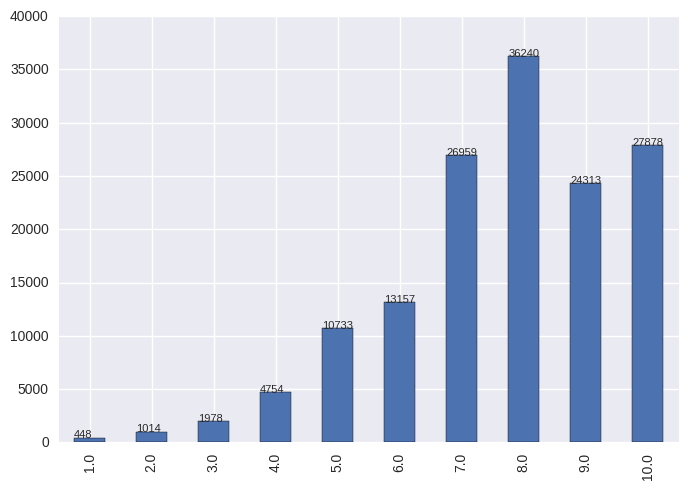

In [3]:
ax = df["CSI"].value_counts().sort_index().plot(kind="bar")
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x(), p.get_height()), size=8)

## Feature selection and preparation
Nothing smart being done here at the moment, just removing features like different IDs that most likely does not correlate with the CSI.

We also apply feature normalization to avoid problems with some classifiers and clustering techniques. This also makes sense because of the fact that the features are very different and given in many different measurement units.

In [5]:
features = df[
    [c for c in df.columns if c.startswith("ShareBought")] +
    [
        "Gender",
        "CSIaverage",
        #"InterviewDate",
        "BirthYear", 
        "PurchasingPower", 
        "VisitsLast3Months", 
        "AmountLast3Months",
        "StoreSquaremeters",
        "DistanceToStore"
    ]]

labels = df["CSI"]

x_test, y_test = features.iloc[test.index], labels.iloc[test.index]
x_train, y_train = [df.iloc[~df.index.isin(test.index)] for df in [features, labels]]

# TODO: dont normalize discrete features maybe? like gender for example
# Normalize each feature
x_train_mean = x_train.mean()
x_train_max = x_train.max()
x_train_min = x_train.min()
x_train = (x_train - x_train_mean) / (x_train_max - x_train_min)
x_test = (x_test - x_train_mean) / (x_train_max - x_train_min)

## Feature correlations
Sometimes it might be interesting to look at correlations in the features which is easily done with Pandas. In this case nothing really sticks out that much though, however there is a slight positive correlation of people who buy a lot of ecological stuff and a lot of fruits and vegetables which seems to make sense. And people who spend more money in the beverage section spend less (negative correlation) in the dairy department.

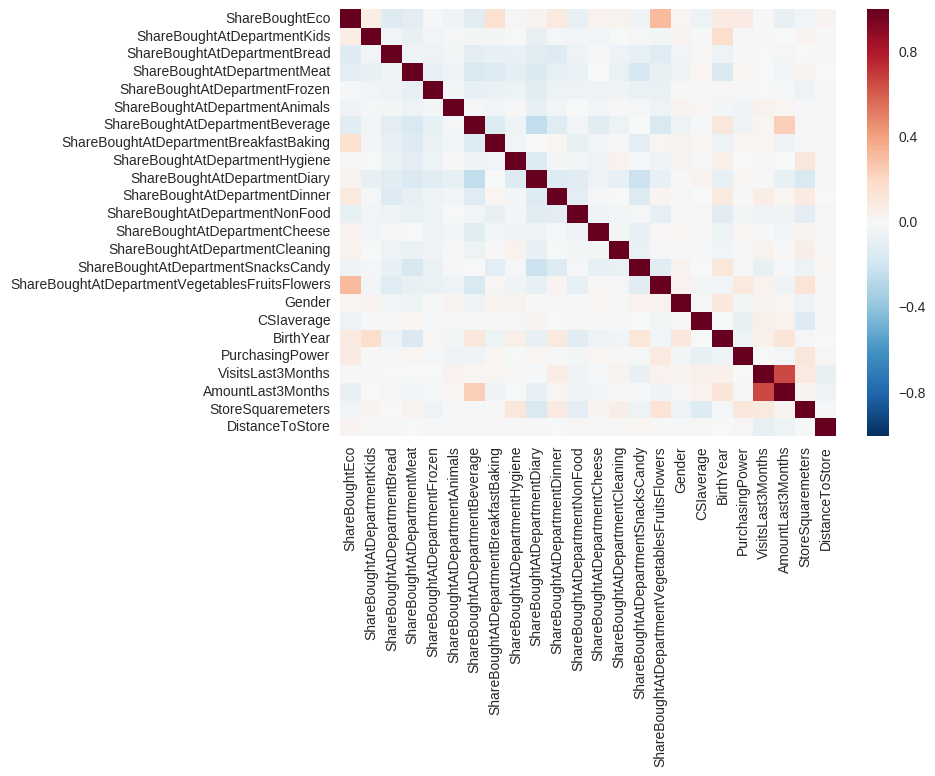

In [5]:
corr = features.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

## Classification performance
Next we'll try to fit some basic sklearn classifiers to see what kind of predictive performance we can get with them on the test set. We perform a grid search over some classifier parameters for each classifier to find the "best" ones. Since this is a multilabel dataset, just reporting the accuracy of a classifier can be somewhat misleading since a classifier that always outputs 8 would get an accuracy of about TODO.

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support, classification_report
from sklearn.model_selection import GridSearchCV
from multiprocessing import Pool, cpu_count

csi_labels = np.arange(1, 11)

def grid_search(clf, params):
    gs = GridSearchCV(clf, params, n_jobs=cpu_count(), verbose=1)
    gs.fit(x_train, y_train)
    predictions = gs.best_estimator_.predict(x_test)
        
    overall_accuracy = (y_test == predictions).sum() / y_test.size
    precisions, recalls, fscores, _ = precision_recall_fscore_support(y_test, 
                                                                      predictions, 
                                                                      labels=csi_labels, 
                                                                      average=None)
    
    estimator_name = type(gs.best_estimator_).__name__
    best_params_strs = ["{}={}".format(arg, val) for arg, val in gs.best_params_.items()]
    estimator_str = estimator_name + "({})".format(",".join(best_params_strs))
    
    return tuple([estimator_str, overall_accuracy] + [pr for pr in zip(precisions, recalls)])

classifiers_to_try = [
    (KNeighborsClassifier(), {"n_neighbors": (5, 10, 15)}),
    (RandomForestClassifier(), {"n_estimators": (10, 20, 50)}),
    (AdaBoostClassifier(), {"n_estimators": (25, 50, 100, 200), 
                            "base_estimator": [None, DecisionTreeClassifier(max_depth=2)]})
]

classifier_scores = [grid_search(clf, params) for clf, params in classifiers_to_try]
columns = ["estimator", "accuracy"] + ["P, R @ label {}".format(l) for l in csi_labels]

old_col_width = pd.get_option('display.max_colwidth')
pd.set_option('display.max_colwidth', -1)
prediction_results = pd.DataFrame.from_records(classifier_scores, columns=columns)
pd.set_option('display.max_colwidth', old_col_width)

prediction_results

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=3)]: Done   9 out of   9 | elapsed: 11.7min finished


Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=3)]: Done   9 out of   9 | elapsed:   26.3s finished


Fitting 3 folds for each of 8 candidates, totalling 24 fits


/home/john/opt/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=3)]: Done  24 out of  24 | elapsed:  4.5min finished
/home/john/opt/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,estimator,accuracy,"P, R @ label 1","P, R @ label 2","P, R @ label 3","P, R @ label 4","P, R @ label 5","P, R @ label 6","P, R @ label 7","P, R @ label 8","P, R @ label 9","P, R @ label 10"
0,KNeighborsClassifier(n_neighbors=15),0.218154,"(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.1, 0.0161290322581)","(0.111111111111, 0.0502257336343)","(0.11385199241, 0.0549450549451)","(0.205513307985, 0.24804956402)","(0.255591798695, 0.391995711989)","(0.170759350208, 0.131701631702)","(0.23987930601, 0.256451612903)"
1,RandomForestClassifier(n_estimators=50),0.236085,"(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.047619047619, 0.00124069478908)","(0.135542168675, 0.02539503386)","(0.132459970888, 0.0416666666667)","(0.215799288015, 0.292106470858)","(0.258251138088, 0.486510630695)","(0.163461538462, 0.0792540792541)","(0.270895971137, 0.242204301075)"
2,"AdaBoostClassifier(base_estimator=None,n_estim...",0.262825,"(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.142857142857, 0.00677200902935)","(1.0, 0.000457875457875)","(0.223183391003, 0.177604405691)","(0.264711802993, 0.704841879578)","(0.25, 0.000291375291375)","(0.292403486924, 0.315591397849)"


As we can see from the warnings, the last two classifiers do not predict certain CSI values even once which makes the computation of precision undefined. This is mainly because of the skewed distribution in our data, we don't really have enough samples of the lower CSI values so if prediction performance is the most important goal, other methods should probably be explored. Maybe something bayesian.

## Clustering
Next we might want to try to find some patterns in the customer data to see if there are perhaps different types of customers that are alike. KMeans is an easy thing to start with but choosing the K-parameter can be tricky. One way to do it is the *elbow-method* which is basically just to visually detect the change point of the decreasing distances from assigned cluster index's centroid when the number of clusters increases by looking at a graph.

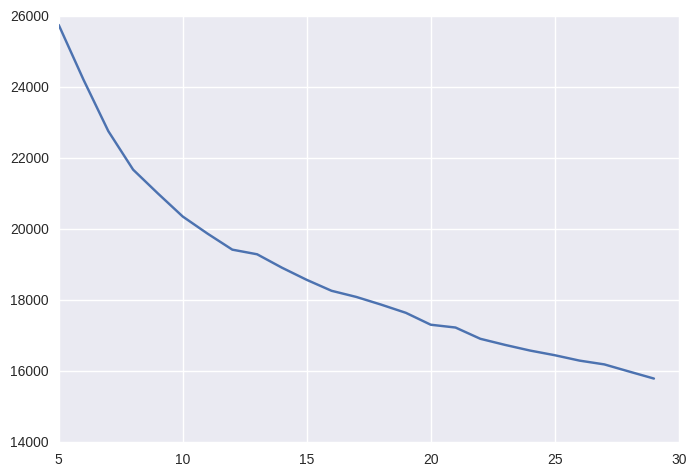

In [7]:
from sklearn.cluster import KMeans

# Try to find a good K for KMeans via the elbow method 
# on the squared sum of distances to assigned cluster
# centers.
def evaluate_kmeans(k):
    kmeans = KMeans(n_clusters=k, random_state=123)
    centroid_dists = kmeans.fit_transform(x_train)
    assigned_centroid_dists = centroid_dists.min(axis=1)
    return (assigned_centroid_dists ** 2).sum()

ks = range(5, 30)
plt.plot(ks, [evaluate_kmeans(k) for k in ks])
plt.show()

We don't really see a very defined elbow. Maybe the data is mostly just randomly spaced out in the feature space. KMeans as a clustering algorithm also has some drawbacks and is not suitable for some type of clusters as can be seen [here](http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html).

## High dimensional visualisation
Can we visualise all the dimensions of the data we have for each customer in any meaningful way? One way is to just plot all the features on axes parallel to each other using different colors for each CSI value to see if there is any pattern to be found. I scaled the features for this since Pandas parallel coordinates plot doesn't have independent scaling per axis.

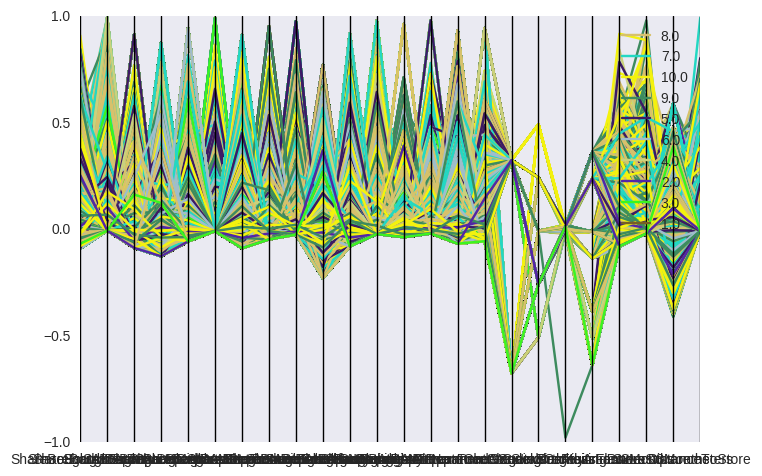

In [22]:
from pandas.tools.plotting import parallel_coordinates

#feats = features.drop(["DistanceToStore", "AmountLast3Months"], axis=1)
feats = (features - features.mean()) / (features.max() - features.min())
feats = pd.concat((feats, labels), axis=1)
parallel_coordinates(feats, "CSI")

We can also use a dimensionality reduction technique called *t-distributed stochastic neighbor embedding* (TSNE) which is a way to visualize high dimensional data. At least with the standard parameter settings we don't really see anything interesting though, there is no apparent separation of CSI labels for different feature vectors.

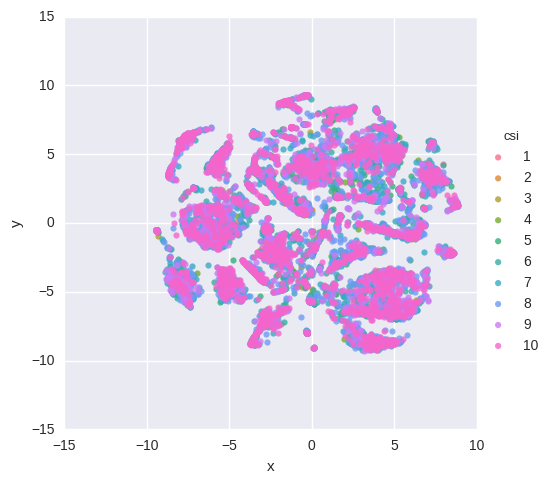

In [6]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_limit = 10000 # sklearn tsne gives memory error if passing all rows even with 16g RAM :/
indexes = np.random.choice(len(x_train), tsne_limit, replace=False)
y_train_tsne = y_train[indexes]
x_train_tsne = tsne.fit_transform(x_train.iloc[indexes])

tsne_df = pd.DataFrame({"x": x_train_tsne[:, 0], 
                        "y": x_train_tsne[:, 1], 
                        "csi": y_train_tsne.apply(int)})
sns.lmplot("x", "y", data=tsne_df, hue="csi", fit_reg=False)

## Summary
In this notebook, a few basic data science techniques are demonstrated. I never really made any interesting discoveries though which either might be indicative of me doing something wrong or that maybe there is just a really weak signal in this data. Maybe people's rating of their experience is mostly just dependent on how they are treated by the store's employees which is not really captured in the features we have in this data set.

Other things that would be interesting to explore could be to look at the most important features found in the decision tree based classifiers.